## Goal: Correlate the number of variants from known (v47) SS-proximal regions (+-1.6kb) with the number of added SJs uniq to personalized GRCh38s

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [31]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

1097448
1422991


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


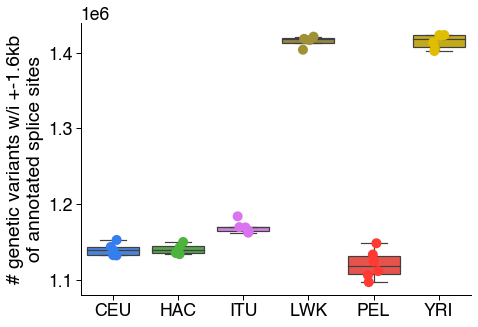

In [32]:
# load the nvars
var_df = pd.read_csv(proc_cfg(config['1000g']['n_ss_intersect_summary'], od), sep='\t')
var_df['cell_line_id'] = var_df.cell_line_id.str.rsplit('/', expand=True, n=1)[1]

# range
print(var_df.n_vars.min())
print(var_df.n_vars.max())

var_df = var_df.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

# plot n_vars by pop
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=var_df.population.unique().tolist())
ax = sns.boxplot(var_df,
            x='population',
            y='n_vars',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='n_vars', data=var_df, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [14]:
file = proc_cfg(config['lr']['td_personal']['sqanti']['sj_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel sjs and count per cell line
temp = df.loc[df.junction_novelty=='novel']

# get only the detection from mapping
temp = temp[['sj_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['sj_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_novel_sj'] = temp.groupby('cell_line_id')['sj_id'].transform('nunique')

# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_novel_sj'] = temp.groupby('cell_line_id')['sj_id'].transform('nunique')

0.1880878635999897
0.31956844481234564

0.21379310344827587
0.256621454939998


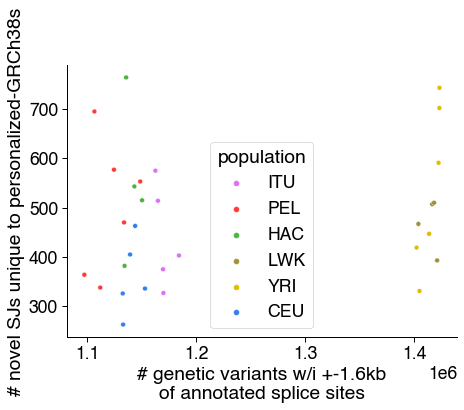

In [33]:
# add number of non-hg38 discovered novel SJs
var_df = var_df.merge(temp[['cell_line_id', 'n_non_hg38_novel_sj']].drop_duplicates(),
                      on='cell_line_id')

# correlate!
ax = sns.scatterplot(var_df, y='n_non_hg38_novel_sj', x='n_vars',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# novel SJs unique to personalized-GRCh38s',
       xlabel='# genetic variants w/i +-1.6kb\nof annotated splice sites')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

x = var_df.n_non_hg38_novel_sj.tolist()
y = var_df.n_vars.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)